In [1]:
# set default dir
import os
os.chdir("../..")

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
import numpy
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import datetime
from IPython.display import display, clear_output
import pathlib
import pickle

from src.poisson.lambda_fun import lambdaSpline
from src.poisson.projector import posPolyCoefProjector
from src.poisson.regression import PoissonRegr

## Data Extraction

In [3]:
raw_data = pd.read_csv("data/train.csv")
raw_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
FAMILY = "AUTOMOTIVE"
STORE_NUM = 33
START_DATE = pd.Timestamp("2014-01")

data = raw_data.loc[
    (pd.to_datetime(raw_data["date"]) >= START_DATE) & (raw_data["family"] == FAMILY) & (raw_data["store_nbr"] == STORE_NUM),
    ["date", "sales", "onpromotion"]
]
data["date"] = data["date"].apply(pd.to_datetime)

print("Sample size", data.shape[0])
data.head()

Sample size 1320


,date,sales,onpromotion
649506,2014-01-01,0.0,0
651288,2014-01-02,7.0,0
653070,2014-01-03,5.0,0
654852,2014-01-04,2.0,0
656634,2014-01-05,16.0,0


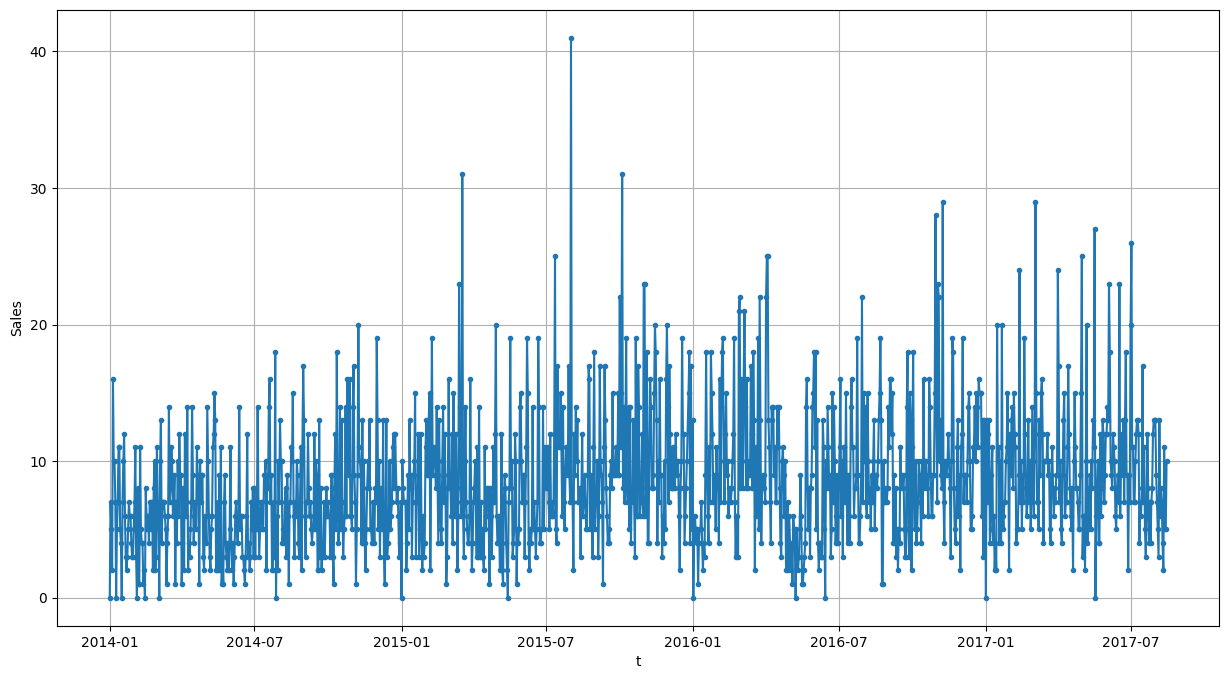

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(data["date"], data["sales"], marker=".")

ax.grid(True)
ax.set_ylabel("Sales")
ax.set_xlabel("t");

In [6]:
SPLIT_DATE = pd.Timestamp("2017-01-01")

train_data = data[data["date"] < SPLIT_DATE]
test_data = data[data["date"] >= SPLIT_DATE]

print("Train size", train_data.shape[0])
print("Test size", test_data.shape[0])

Train size 1093
Test size 227


## Model, optimizer, metrics

In [7]:
lambda_spline = lambdaSpline(order=8)
pois_model = PoissonRegr(lambda_spline, [train_data])

In [8]:
# debug
model_params = list(lambda_spline.parameters())

In [9]:
constraint_projector = posPolyCoefProjector(lambda_spline) 
# first align of the polys parameters
constraint_projector.Project()

LR_START = 1e-2
optimizer = optim.SGD(lambda_spline.parameters(), lr=LR_START)
# constant step
lr_sched = LambdaLR(optimizer, lambda k: LR_START)

In [10]:
max_epochs = 1000
# tolerance for gradient of the optimized function
grad_eps = 1e-5

In [11]:
# create tensorboard dir
logdir = f"experiments/AUTOMOTIVE/tensorboard"
pathlib.Path(logdir).mkdir(exist_ok=True, parents=True)

# create tensorboard writer
writer = SummaryWriter(logdir)

In [12]:
def saveTestMetrics(writer: SummaryWriter, 
                    epoch: int,
                    pois_model: PoissonRegr, 
                    test_data: pd.DataFrame, 
                    train_data: pd.DataFrame
) -> None:
    with torch.no_grad():
        # Test Liklyhood metric
        pois_model.setData([test_data])
        writer.add_scalar("Test/test_neg_logLH", -pois_model.lnLiklyhood(), epoch)
    
        # Kaggle prediction metric
        observations = torch.from_numpy(test_data["sales"].values).to(torch.float64)
        prediction = torch.round(pois_model.getLambdas(test_data))
        writer.add_scalar("Test/Kaggle_metric", 
                          torch.sqrt(torch.mean((torch.log(1 + prediction) - torch.log(1 + observations)) ** 2)),
                          epoch
        )
    
        # return train data to pois_model
        pois_model.setData([train_data])

## Training

Gradient decsend with constraint projection

In [13]:
for epoch in range(max_epochs):
    # debug
    clear_output()
    display(f"Epoch {epoch}")

    # gradient step
    optimizer.zero_grad()

    cur_LH = -pois_model.lnLiklyhood()

    cur_LH.backward()
    # nn.utils.clip_grad_norm(lambda_spline.parameters(), max_norm=1e3)
    optimizer.step()
    lr_sched.step()

    # parameters projection on constraints
    constraint_projector.Project()

    # metrics
    saveTestMetrics(writer, epoch, pois_model, test_data, train_data)
    with torch.no_grad():
        writer.add_scalar("Train/neg_logLH", cur_LH, epoch)
        
        cur_grad_norm = torch.zeros(1)
        for param in lambda_spline.parameters():
            cur_grad_norm += torch.sum(param.grad ** 2)
        cur_grad_norm = torch.sqrt(cur_grad_norm) / len(list(lambda_spline.parameters()))
        writer.add_scalar("Train/grad_norm", cur_grad_norm, epoch)

    # termination case
    if cur_grad_norm < grad_eps:
        break

'Epoch 999'

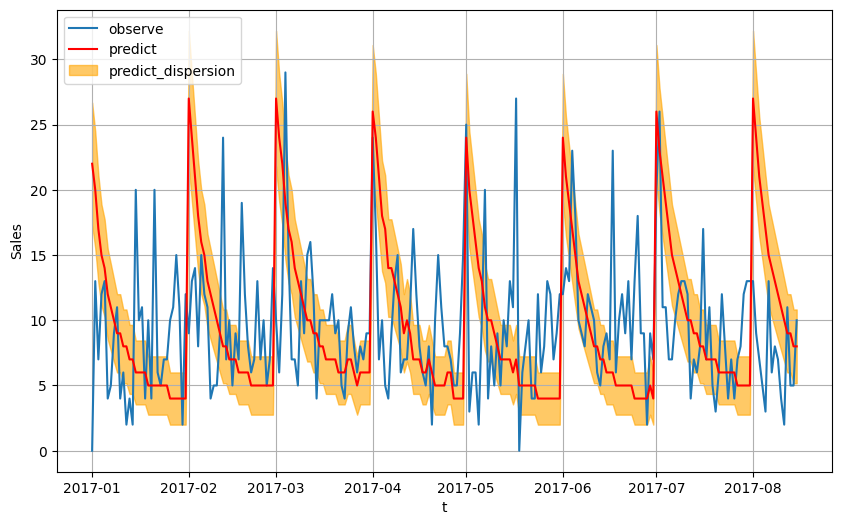

In [14]:
# vizualize solution
observations = test_data["sales"].values
prediction = torch.round(pois_model.getLambdas(test_data)).numpy()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(test_data["date"].values, observations, label="observe")
ax.plot(test_data["date"].values, prediction, label="predict", color="red")
ax.fill_between(test_data["date"].values, prediction - np.sqrt(prediction), prediction + np.sqrt(prediction), 
                color="orange", alpha=0.6, label="predict_dispersion"
)

ax.grid(True)
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("Sales");

In [15]:
# look at the coeffs
for key, param in lambda_spline.state_dict().items():
    print(key, param)

_promotion_c tensor([1.0311], dtype=torch.float64)
_polys.0 tensor([2.5431, 2.5019, 2.2193, 2.3794, 2.2374, 2.2227, 1.9414, 2.0733, 4.0478],
       dtype=torch.float64)
_polys.1 tensor([3.1608, 3.3224, 3.1717, 2.2308, 3.0756, 3.0600, 2.5880, 2.3760, 4.4698],
       dtype=torch.float64)
_polys.2 tensor([2.9907, 2.6951, 3.0409, 2.9186, 2.1783, 2.9717, 2.6264, 2.8246, 5.0640],
       dtype=torch.float64)
_polys.3 tensor([3.0970, 2.6103, 3.1827, 2.4985, 2.2206, 2.5993, 2.8079, 3.0622, 4.0103],
       dtype=torch.float64)
_polys.4 tensor([2.5134, 2.8267, 2.7253, 2.8086, 2.0353, 2.4223, 2.1147, 1.8463, 3.8317],
       dtype=torch.float64)
_polys.5 tensor([2.4548, 2.8388, 2.9499, 2.9721, 2.4004, 2.4275, 2.0976, 2.4942, 3.7957],
       dtype=torch.float64)
_polys.6 tensor([2.5940, 2.3187, 3.1041, 2.8631, 2.3235, 2.8739, 2.1979, 3.0821, 4.9871],
       dtype=torch.float64)
_polys.7 tensor([2.9867, 3.3612, 2.4763, 2.7152, 2.2217, 2.6968, 2.6973, 2.7170, 4.8701],
       dtype=torch.float64)
_poly

In [16]:
writer.close()

In [17]:
# create models dir
model_dir = f"experiments/AUTOMOTIVE/artifacts"
pathlib.Path(model_dir).mkdir(exist_ok=True, parents=True)

# save model parameters
with open(f"{model_dir}/lambda_spline.pkl", "wb") as f:
    pickle.dump(lambda_spline, f)
with open(f"{model_dir}/projector.pkl", "wb") as f:
    pickle.dump(constraint_projector, f)